In [1]:
import os
import glob
import rosbag
import pandas as pd
import numpy as np
import cv2
import time 

from os import path
import matplotlib.pyplot as plt
from utils.visualisation import *
from utils.postprocessing.utils import csvs2dfs
from functools import reduce
from utils.postprocessing.config import Config


/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Visualize the simulation
Visualize the robot's simulation on a specific map is tremendously to understand if everything went perfect. Also, we can have an idea about the generated dataset.

In [17]:
MAP_NAME = 'querry-big'
MAPS_DIR = '/home/francesco/Desktop/carino/vaevictis/data/maps'

In [18]:
csvs_paths = glob.glob('/home/francesco/Desktop/data/test/csvs/{}/*.csv'.format(MAP_NAME))
# csvs_paths = glob.glob('/home/francesco/Desktop/data/csv/querry/*.csv')
len(csvs_paths)

51

In [19]:
dfs = csvs2dfs(csvs_paths)

In [20]:
hm = cv2.imread('{}/{}.png'.format(MAPS_DIR, MAP_NAME))
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)

## Visualize the robot's trace
Below we plotted all the robot's positions for the given map

In [21]:
plt.rcParams['figure.figsize'] = (6,6)

<IPython.core.display.Javascript object>


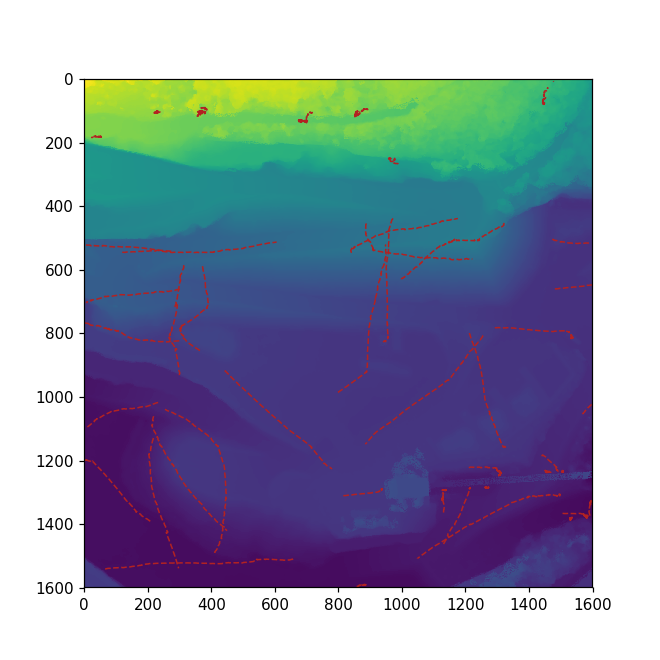

<IPython.core.display.Javascript object>


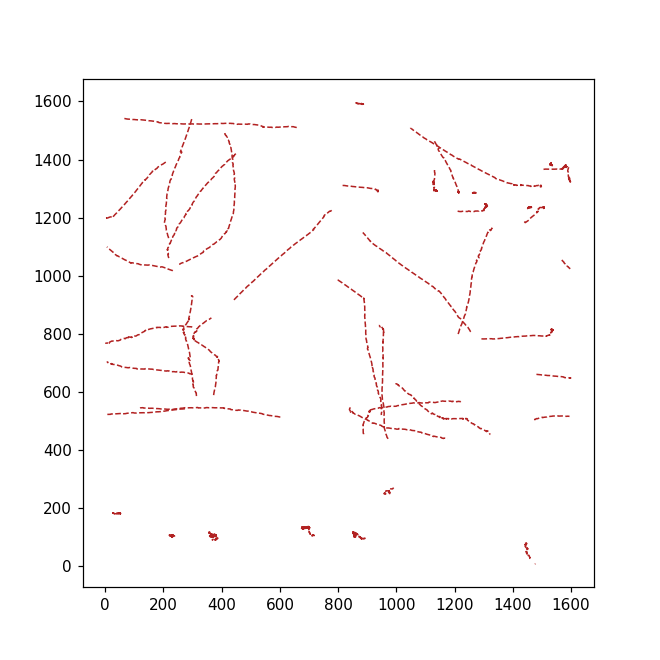

In [22]:
show_traces(dfs, hm)
show_naked_traces(dfs)

## Plotting statistics

In [23]:
df_total = pd.concat(dfs)
df_total = df_total.dropna()
df_total = df_total.reset_index() # we need to reset the index otherwise the plots are based on the old overlapping indexes

### Advancement
Below we show a box plot of the advancement

<IPython.core.display.Javascript object>


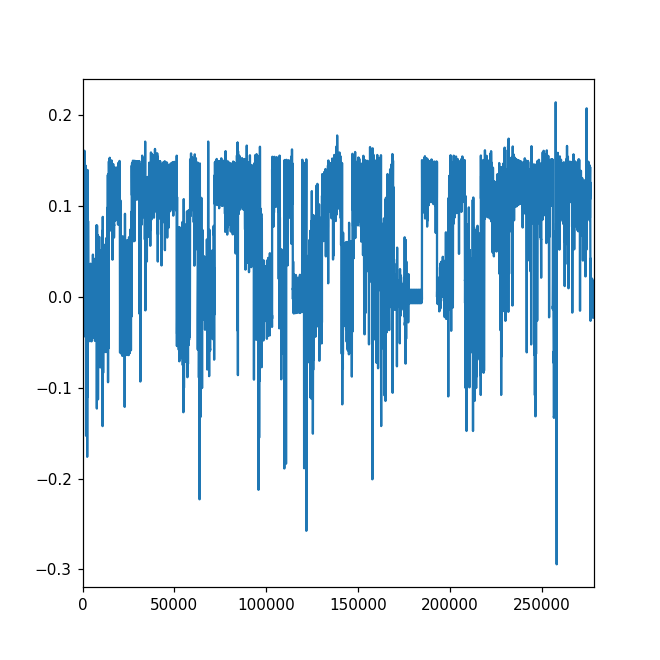

In [24]:
fig = plt.figure()
df_total['advancement'].plot.line()

<IPython.core.display.Javascript object>


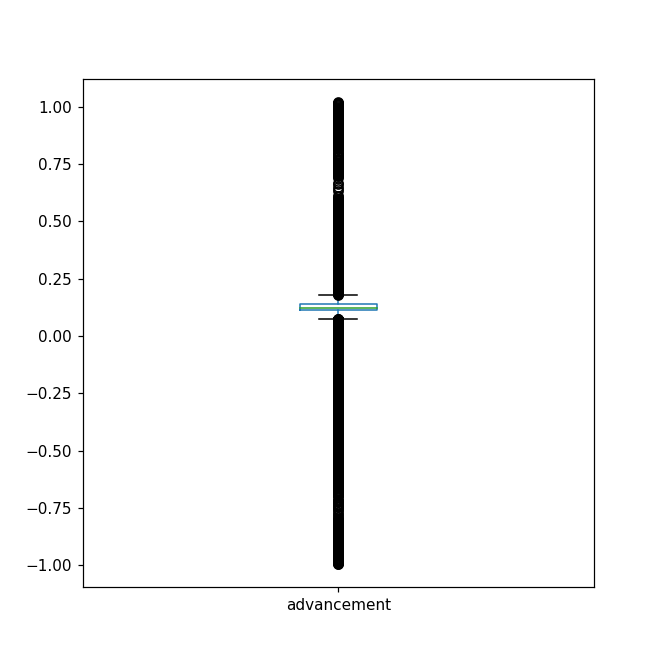

0.10970583808998641

In [11]:
fig = plt.figure()
df_total['advancement'].plot.box()
df_total['advancement'].mean()

In [25]:
df_total['advancement'].min()

-0.2944148412014205